# Fined Grained Visual Classification of Aircraft
### Building a model that will classify airplane model from images

### About the data

This project used the Fine-Grained Visual Classification of Aircraft (FGVC-Aircraft) dataset. This dataset contains thousands of pictures of different aircraft models in different settings. This extensively labeled dataset was made possible by a number of airplane spotters for non-commercial research purposes only.

This dataset contains a total of 10,000 images of aircraft and is split in the following way:
- 3334 Training Images
- 3333 Validation Images
- 3333 Testing Images

The interesting thing about this Dataset is that it includes txt files containing different hierarchical levels of airplane labels. There are three levels in the hierarchy, organized from finer to coarser in the following way:

- *Variant*: e.g. Boeing 737 - 700. As per the dataset page: “A variant collapses all the models that are visually indistinguishable into one class. The dataset comprises 102 different variants.”
- *Family*: e.g Boeing 737. For example, all of the 737 variants (737-200, 737-300) would be grouped into the same family. The dataset comprises 70 different variants. 
- *Manufacturer* e.g. Boeing. The dataset comprises 41 different manufacturers.

This dataset was used as a part of the fine-grained recognition challenge “FGComp2013” and is considered a benchmark for FGVC. 

Aircraft is one of the most interesting case uses in FGVC for many reasons. First, aircraft have been around for more than 100 years. In this span, aircraft design has evolved vastly, from structural changes to propulsion. All of these differences in propulsion, wing configuration, livery and purpose(Civil, Military) provide a very different range of challenges than the typical Fined Grained Classification subjects like cats or birds.  

### About to Fined Grained Classifiers

This project explores fine-grained classification, i.e. classification among categories which are are both visually and semantically very similar. This is a very difficult regime which is even challenging for humans without careful training, and is critical for establishing a more detailed understanding of the visual world.


### Importance
Fined grained classification is a very exciting task, but it doesn't stop there. Identifying different subclasses of airplane might be extremely useful in a diverse range of environments. 

#### Importing Libraries 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from PIL import Image
import keras
from keras.models import Sequential 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential

In [4]:
import tensorflow as tf

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2

#### Set up Directories:

In [6]:
train_dir = "./split_data/train/"
val_dir = "./split_data/val/"
test_dir = "./split_data/test/"

In [17]:
#Normalize and Prepare Pictures
train_datagen = ImageDataGenerator(rescale=1/255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255) 

In [18]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(64, 64),
                                                 batch_size=32, 
                                                 class_mode="categorical")

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(64,64),
                                                        batch_size=32,
                                                        class_mode="categorical"
                                                        )

test_set = test_datagen.flow_from_directory(test_dir,
                                           target_size=(64,64),
                                           class_mode="categorical",
                                           batch_size=32)
                                            

Found 3334 images belonging to 100 classes.
Found 3333 images belonging to 100 classes.
Found 3333 images belonging to 100 classes.


### Data exploration

Let's take a look at the images we'll be working with:

In [87]:
training_df = pd.read_csv("./Data/archive/train.csv")

In [89]:
training_df.head()

filename  Classes  Labels
0  1025794.jpg  707-320       0
1  1340192.jpg  707-320       0
2  0056978.jpg  707-320       0
3  0698580.jpg  707-320       0
4  0450014.jpg  707-320       0

Here we can see all of the image filenames with their respective class labels of the training set. Let’s take a look at what these images look like:

In [104]:
sample = training_df["filename"].sample(3).values

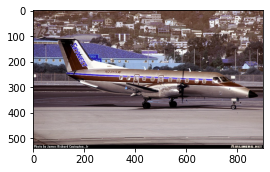

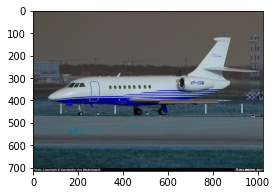

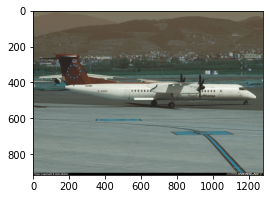

In [106]:
i = 0
for image in sample: 
    fig = plt.figure(figsize=(14, 10))
    a=fig.add_subplot(1,3,i+1)
    path = image
    src = os.path.join("./Data/archive/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/", path)
    image = cv2.imread(src)
    imgplot = plt.imshow(image)
    i += 1

Notice that there are different aircraft sizes and configurations in the dataset. Let's take a look at how our training data is distributed:

<AxesSubplot:>

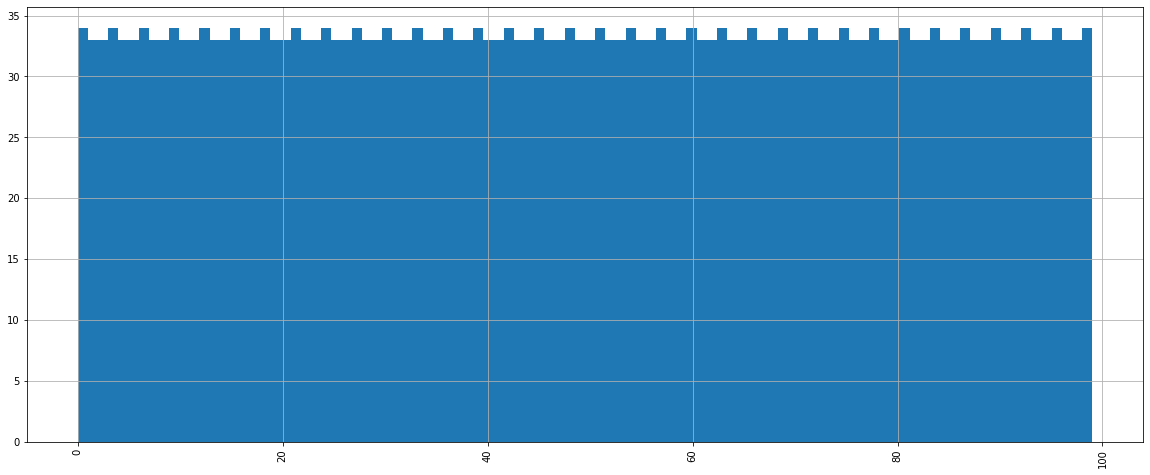

In [148]:
training_df['Labels'].hist(figsize=(20,8),xrot=90, bins=100)

All of the classes contain approximately the same number of images during training, which means we have a pretty balanced dataset for training.

Now let's take a look at some of the validation data, since we want to be able to know what we'll be fighting against.

In [141]:
def show_image(img):
    fig = plt.figure(figsize=(8, 6))
    src = os.path.join("./Data/archive/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/", img)
    image = cv2.imread(src)
    imgplot = plt.imshow(image)

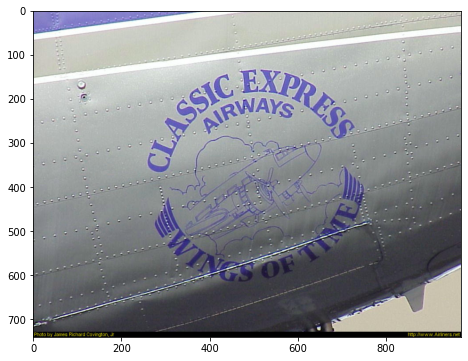

In [142]:
show_image("0045133.jpg")

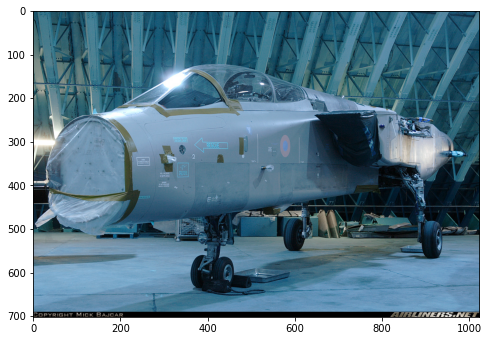

In [143]:
show_image("1408735.jpg")

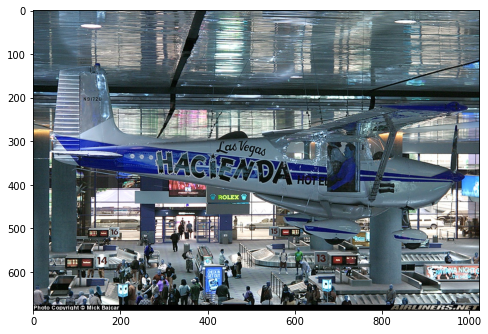

In [144]:
show_image("0847262.jpg")

You can see that our model will really be tested because many of these pictures aren't as clear as our training examples. Many of them do not even include functional aircraft (pictures of airplanes in junkyards and museum are included in the validation) which means our model's ability to generalize will really be put to the test.

## Basic, Naive Model 

Let's test a very basic model, which includes all of the buildings commonly used in CNN image recognition tasks.

In [13]:
model = Sequential([
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(256, 3, activation='relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(100, activation='softmax')
])
model.compile(optimizer='adam',
             loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(training_set, epochs=15, batch_size=32, validation_data=validation_generator)

Epoch 1/15
105/105 [==============================] - 86s 815ms/step - loss: 4.6069 - accuracy: 0.0096 - val_loss: 4.6036 - val_accuracy: 0.0147
Epoch 2/15
105/105 [==============================] - 85s 813ms/step - loss: 4.5804 - accuracy: 0.0117 - val_loss: 4.5772 - val_accuracy: 0.0168
Epoch 3/15
105/105 [==============================] - 85s 808ms/step - loss: 4.5460 - accuracy: 0.0189 - val_loss: 4.5631 - val_accuracy: 0.0183
Epoch 4/15
105/105 [==============================] - 84s 806ms/step - loss: 4.5041 - accuracy: 0.0273 - val_loss: 4.5544 - val_accuracy: 0.0225
Epoch 5/15
105/105 [==============================] - 84s 804ms/step - loss: 4.4667 - accuracy: 0.0330 - val_loss: 4.5649 - val_accuracy: 0.0234
Epoch 6/15
105/105 [==============================] - 84s 805ms/step - loss: 4.4401 - accuracy: 0.0351 - val_loss: 4.5332 - val_accuracy: 0.0300
Epoch 7/15
105/105 [==============================] - 84s 806ms/step - loss: 4.3917 - accuracy: 0.0426 - val_loss: 4.5542 - val_ac

Accuracy doesn't seem to be getting too good with each epoch.

In [14]:
model.evaluate(validation_generator)

105/105 [==============================] - 42s 400ms/step - loss: 4.2375 - accuracy: 0.0960


[4.237545490264893, 0.09600960463285446]

Let's go ahead and proceed to the most commonly used tactic in fined grained classification: Transfer Learning.

# Densenet

In [20]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras import activations as Ac

Let's try using a pretrained network and hooking it up with 2 additional dense layers. We'll top it off with our output layer.

In [9]:
def mish(x):
    return x * K.tanh(Ac.softplus(x)) #Mish function includes a custom activation layer

model = tf.keras.Sequential([
        DenseNet201(weights = 'imagenet', #Pretrained with imagenet custom 
                       include_top = False,
                       input_shape = (299, 299, 3)),
    
        GlobalAveragePooling2D(),
        Dense(1024, activation = mish),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation = mish),
        BatchNormalization(),
        Dropout(0.5),
        Dense(100, activation = 'softmax')
])
    
optimizer = SGD()
model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
    
model.summary()

2021-07-21 10:52:31.147096: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 9, 9, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1967104   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

The model we'll be using as a base is the Densenet model. We'll download the version trained on the Imagenet dataset, as specified with the argument. Most fgvc tasks are tackled using different transfer models.

The other parameters used to build the model were obtained from other models used in a diverse number of classification tasks.

In [10]:
model.fit(training_set, epochs=20, batch_size=16, validation_data=validation_generator)

2021-07-21 10:53:03.884358: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
105/105 [==============================] - 2097s 20s/step - loss: 5.7720 - accuracy: 0.0198 - val_loss: 4.8150 - val_accuracy: 0.0189
Epoch 2/20
105/105 [==============================] - 2138s 20s/step - loss: 5.0105 - accuracy: 0.0549 - val_loss: 4.2469 - val_accuracy: 0.0576
Epoch 3/20
105/105 [==============================] - 2215s 21s/step - loss: 4.2753 - accuracy: 0.1035 - val_loss: 3.7286 - val_accuracy: 0.1323
Epoch 4/20
105/105 [==============================] - 2140s 20s/step - loss: 3.5289 - accuracy: 0.1731 - val_loss: 3.3884 - val_accuracy: 0.1749
Epoch 5/20
105/105 [==============================] - 2220s 21s/step - loss: 2.9199 - accuracy: 0.2645 - val_loss: 3.2893 - val_accuracy: 0.1776
Epoch 6/20
105/105 [==============================] - 2133s 20s/step - loss: 2.5681 - accuracy: 0.3332 - val_loss: 2.3529 - val_accuracy: 0.3657
Epoch 7/20
105/105 [==============================] - 2185s 21s/step - loss: 2.0827 - accuracy: 0.4349 - val_loss: 1.9424 - val_ac

Huge improvement in both our training accuracy and validation accuracy

In [11]:
model.save("./models/densenet/")

2021-07-22 10:00:58.346612: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/densenet/assets


In [12]:
model.evaluate(test_set)

105/105 [==============================] - 413s 4s/step - loss: 1.2473 - accuracy: 0.6538


[1.2473139762878418, 0.6537653803825378]

In [39]:
model_test = keras.models.load_model("./models/densenet/")

In [14]:
model_test.evaluate(validation_generator)

105/105 [==============================] - 558s 5s/step - loss: 1.3148 - accuracy: 0.6472


[1.3147706985473633, 0.6471647024154663]

## Airplane Family 

### Load Data

In [42]:
for i in range(0,9):
    model_densenet.layers[i].trainable = False

In [43]:
for layer in model_densenet.layers:
    print(layer.name, layer.trainable)


densenet201 False
global_average_pooling2d False
dense False
batch_normalization False
dropout False
dense_1 False
batch_normalization_1 False
dropout_1 False
dense_2 False


In [44]:
extracted_layers = model_densenet.layers
extracted_layers.append(keras.layers.Dense(70,activation="softmax", name="dense_3"))
model_families = keras.Sequential(extracted_layers)
model_families.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 9, 9, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1967104   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)              

In [45]:
optimizer = SGD(learning_rate=0.01)
model_families.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [46]:
model_families.fit(training_set, epochs=15, batch_size=16, validation_data=validation_generator)

Epoch 1/15
105/105 [==============================] - 871s 8s/step - loss: 4.2507 - accuracy: 0.0212 - val_loss: 4.2407 - val_accuracy: 0.0324
Epoch 2/15
105/105 [==============================] - 829s 8s/step - loss: 4.2339 - accuracy: 0.0472 - val_loss: 4.2263 - val_accuracy: 0.0525
Epoch 3/15
105/105 [==============================] - 1064s 10s/step - loss: 4.2177 - accuracy: 0.0618 - val_loss: 4.2120 - val_accuracy: 0.0732
Epoch 4/15
105/105 [==============================] - 850s 8s/step - loss: 4.2004 - accuracy: 0.0801 - val_loss: 4.1980 - val_accuracy: 0.0864
Epoch 5/15
105/105 [==============================] - 840s 8s/step - loss: 4.1829 - accuracy: 0.0887 - val_loss: 4.1842 - val_accuracy: 0.0867
Epoch 6/15
105/105 [==============================] - 883s 8s/step - loss: 4.1641 - accuracy: 0.1024 - val_loss: 4.1707 - val_accuracy: 0.0831
Epoch 7/15
105/105 [==============================] - 915s 9s/step - loss: 4.1541 - accuracy: 0.0892 - val_loss: 4.1575 - val_accuracy: 0.08

KeyboardInterrupt: 

In [48]:
def img_preprocess(img, target):
    """
    Does preprocessing on image, which includes reading it, cropping the copyright label, resizing it, changing 
    datatype, normalizing the values and adding extra dimension. Function takes a string representing
    an image name file in the format: XXXXXXX.jpg returns a list that contains the arguments
    """
    src = os.path.join("./Data/archive/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/",img)
    image = cv2.imread(src)
    h,w = image.shape[:2]
    cropped = image[0:h-13,0:w]#Crop copyright label from picture
    fig = plt.figure(figsize=(14, 10))
    plt.imshow(cropped)
    plt.title("Trying to classify: " + target)
    dim = (299, 299)
    resized = cv2.resize(cropped, dim, interpolation = cv2.INTER_AREA)#Resize to fit input of model
    resized.astype(float) #Change datatype from uint8 to float
    resized = resized/255
    resized = np.expand_dims(resized, axis=0) #Add dimension to compensate for batch dimension
    return model_family.predict(resized).argsort() #Usinge model.predict for the image
    

def top_3(img, target):
    """
       Takes in filename as an argument and prints examples of the top 3 predictions.
       Function assumes image comes from validation split.
    """
    predictions = img_preprocess(img, target)#function returns a list with predictions in reverse order
    
    fig = plt.figure(figsize=(14, 10))
    top_3_predictions = []
    for prediction in predictions[0,-3:]:#slice list to obtain top 3 prediction classes
        top_3_predictions.append(families_names["family"].loc[prediction])#Name of aircraft obtained from df
    for i in range(0,3):
        a=fig.add_subplot(1,3,i+1)
        path = families.loc[families["Aircraft Family"] == top_3_predictions[2-i]].iloc[0][0]
        src = os.path.join("./Data/archive/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/", path)
        image = cv2.imread(src)
        imgplot = plt.imshow(image)
        a.set_title('Top ' + str(i+1) + " Prediction:" + top_3_predictions[2-i])  
    if target == top_3_predictions[-1]:
        print("Correctly classified as " + target)
    elif target in top_3_predictions:
        print("The correct label was in the top 3 predictions")
    else:
        print("The correct label was not in the top 3 predictions")
    

In [7]:
classes = pd.read_csv("./Data/archive/val.csv")

In [28]:
families_names = pd.read_csv("./Data/archive/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/families.txt")
families = pd.read_csv("./Data/archive/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_family_val.txt")

The correct label was in the top 3 predictions
The correct label was not in the top 3 predictions
Correctly classified as 727-200


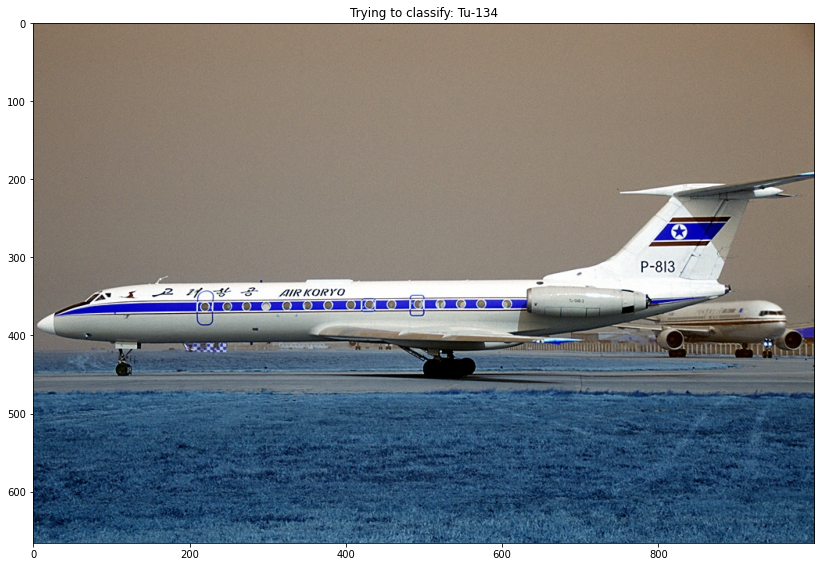

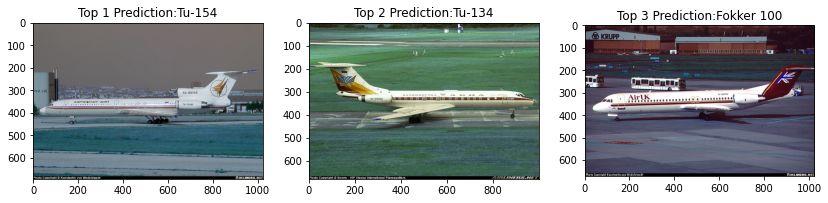

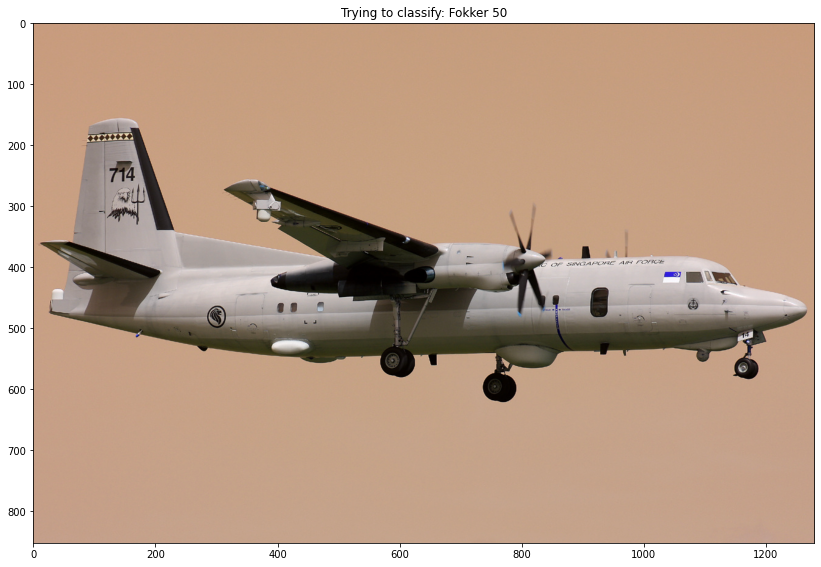

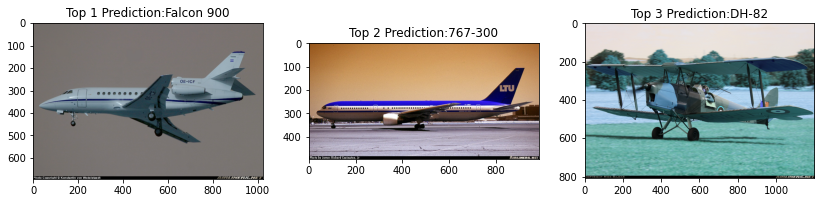

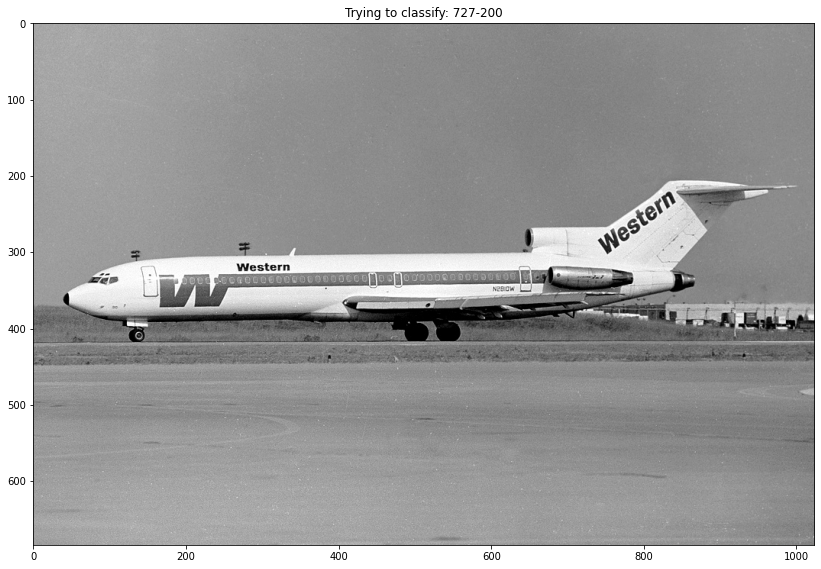

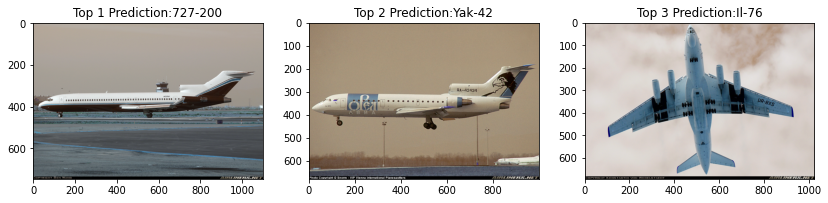

In [260]:
random_images.values
for file, target in random_images.values:
    top_3(file, target)
    

The correct label was not in the top 3 predictions
The correct label was in the top 3 predictions
The correct label was not in the top 3 predictions


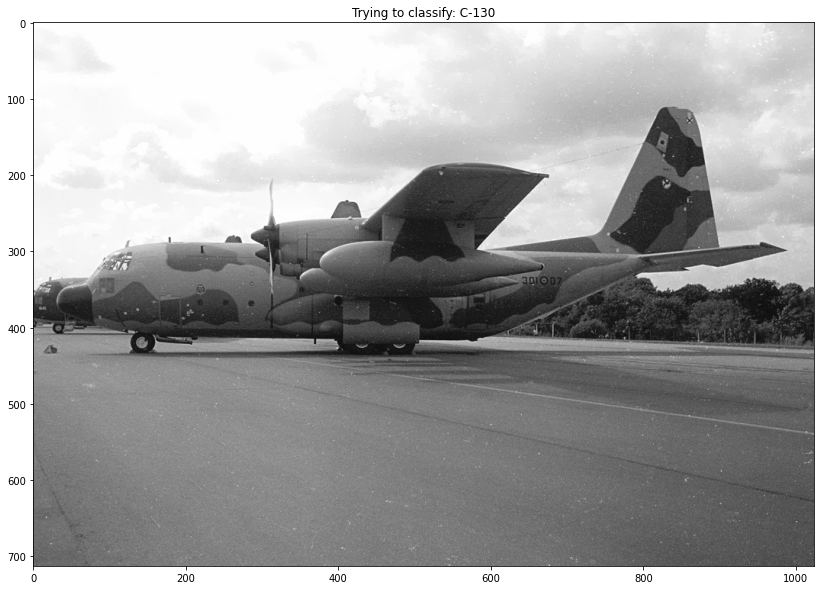

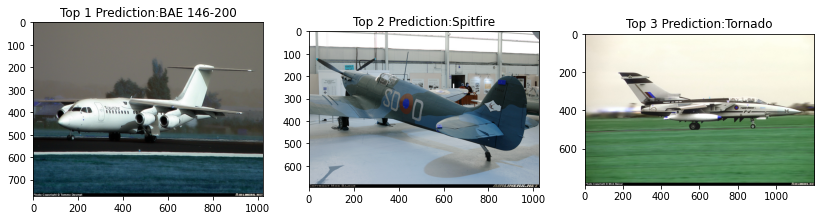

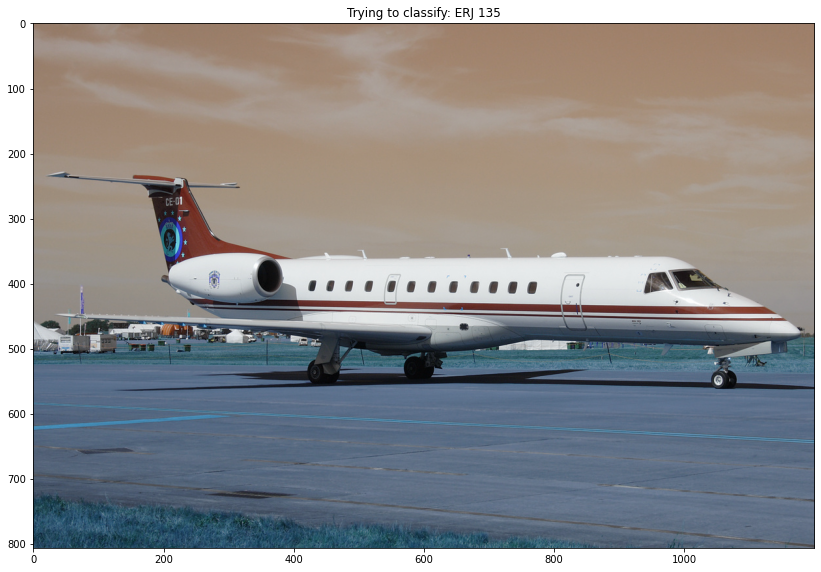

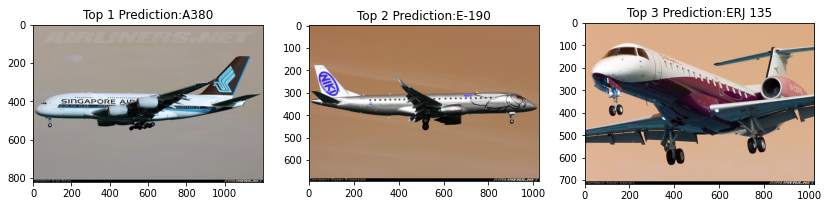

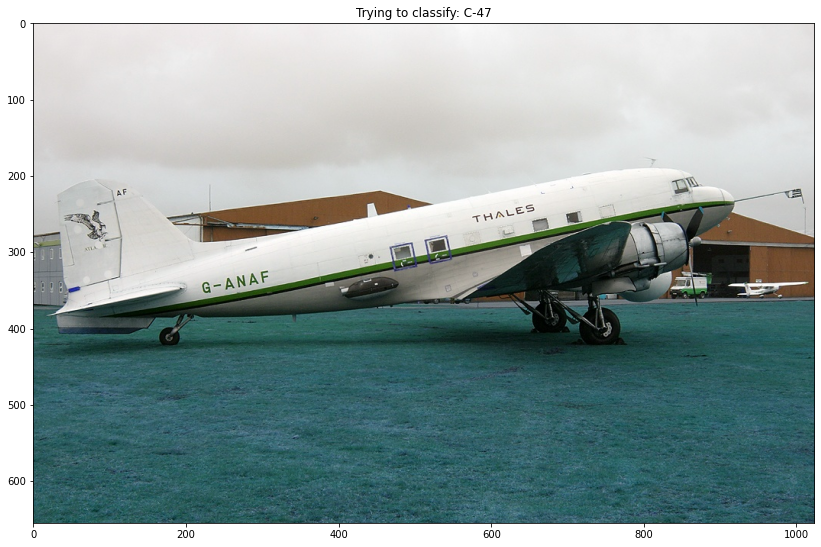

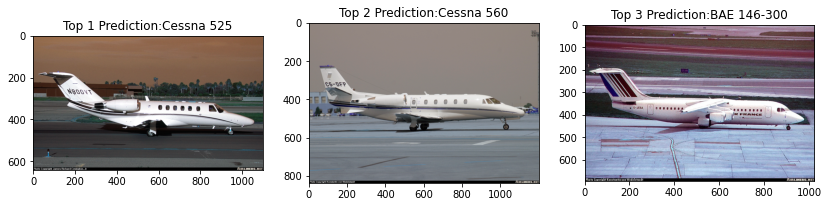

In [264]:
random_images.values
for file, target in random_images.values:
    top_3(file, target)
    

# Families Complete Training

In [26]:
def mish(x):
    return x * K.tanh(Ac.softplus(x))

model_family = tf.keras.Sequential([
        DenseNet201(weights = 'imagenet', 
                       include_top = False,
                       input_shape = (299, 299, 3)),
    
        GlobalAveragePooling2D(),
        Dense(1024, activation = mish),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation = mish),
        BatchNormalization(),
        Dropout(0.5),
        Dense(70, activation = 'softmax')
])
    
optimizer = SGD(learning_rate = 0.01)
model_family.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
    
model_family.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 9, 9, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1967104   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [38]:
train_datagen = ImageDataGenerator(rescale=1/255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255) 

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(64, 64),
                                                 batch_size=32, 
                                                 class_mode="categorical")

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        shuffle=False,
                                                        target_size=(64,64),
                                                        batch_size=32,
                                                        class_mode="categorical"
                                                        )

test_set = test_datagen.flow_from_directory(test_dir,
                                           target_size=(64,64),
                                           class_mode="categorical",
                                           batch_size=32)
                                            

Found 3334 images belonging to 70 classes.
Found 3333 images belonging to 70 classes.
Found 3333 images belonging to 70 classes.


In [28]:
model_family.fit(training_set, epochs=40, batch_size=32, validation_data=validation_generator)

Epoch 1/40
105/105 [==============================] - 258s 2s/step - loss: 5.6419 - accuracy: 0.0198 - val_loss: 6.9296 - val_accuracy: 0.0258
Epoch 2/40
105/105 [==============================] - 271s 3s/step - loss: 5.1947 - accuracy: 0.0306 - val_loss: 5.5434 - val_accuracy: 0.0639
Epoch 3/40
105/105 [==============================] - 268s 3s/step - loss: 4.9248 - accuracy: 0.0414 - val_loss: 4.7389 - val_accuracy: 0.0804
Epoch 4/40
105/105 [==============================] - 267s 3s/step - loss: 4.7144 - accuracy: 0.0594 - val_loss: 4.1289 - val_accuracy: 0.0960
Epoch 5/40
105/105 [==============================] - 269s 3s/step - loss: 4.5542 - accuracy: 0.0684 - val_loss: 3.9714 - val_accuracy: 0.1053
Epoch 6/40
105/105 [==============================] - 270s 3s/step - loss: 4.3860 - accuracy: 0.0951 - val_loss: 3.8110 - val_accuracy: 0.1065
Epoch 7/40
105/105 [==============================] - 265s 3s/step - loss: 4.2497 - accuracy: 0.0954 - val_loss: 3.7217 - val_accuracy: 0.1137

In [238]:
model_family.evaluate(test_set)

105/105 [==============================] - 61s 576ms/step - loss: 2.7366 - accuracy: 0.3825


[2.73663067817688, 0.3825382590293884]

In [37]:
model_family.save("./models/families/model.h5")

## Loading Model After Closing Session 

In [25]:
def custom_activation(x):
    return x * K.tanh(Ac.softplus(x))#Define custom activation

model_family = keras.models.load_model(
    './models/families/model.h5', custom_objects={"mish": custom_activation}#Pass custom activation to custom objects
)

In [12]:
def return_family(element):
    return element[8:]

def return_image(element):
    return element[:7] + ".jpg"

def family_creator(df, classes):
    image_name = df["Image"].apply(return_image).to_frame("image")
    family_name =  df["Image"].apply(return_family).to_frame(classes)
    return pd.concat([image_name, family_name], axis=1)

In [84]:
def img_preprocess(img, target):
    """
    Does preprocessing on image, which includes reading it, cropping the copyright label, resizing it, changing 
    datatype, normalizing the values and adding extra dimension. Function takes a string representing
    an image name file in the format: XXXXXXX.jpg returns a list that contains the arguments
    """
    src = os.path.join("./Data/archive/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/",img)
    image = cv2.imread(src)
    h,w = image.shape[:2]
    cropped = image[0:h-13,0:w]#Crop copyright label from picture
    fig = plt.figure(figsize=(14, 10))
    plt.imshow(cropped)
    plt.title("Trying to classify: " + target)
    dim = (299, 299)
    resized = cv2.resize(cropped, dim, interpolation = cv2.INTER_AREA)#Resize to fit input of model
    resized.astype(float) #Change datatype from uint8 to float
    resized = resized/255
    resized = np.expand_dims(resized, axis=0) #Add dimension to compensate for batch dimension
    return model_families.predict(resized).argsort() #Usinge model.predict for the image
    

def top_3(img, target):
    """
       Takes in filename as an argument and prints examples of the top 3 predictions.
       Function assumes image comes from validation split.
    """
    predictions = img_preprocess(img, target)#function returns a list with predictions in reverse order
    
    fig = plt.figure(figsize=(14, 10))
    top_3_predictions = []
    for prediction in predictions[0,-3:]:#slice list to obtain top 3 prediction classes
        top_3_predictions.append(families_names["family"].loc[prediction])#Name of aircraft obtained from df
    for i in range(0,3):
        a=fig.add_subplot(1,3,i+1)
        path = families.loc[families["Aircraft Family"] == top_3_predictions[2-i]].iloc[0][0]#Get filename for an example
        src = os.path.join("./Data/archive/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/", path)
        image = cv2.imread(src)
        imgplot = plt.imshow(image)
        a.set_title('Top ' + str(i+1) + " Prediction:" + top_3_predictions[2-i])  
    if target == top_3_predictions[-1]:
        print("Correctly classified as " + target)
    elif target in top_3_predictions:
        print("The correct label was in the top 3 predictions")
    else:
        print("The correct label was not in the top 3 predictions")
    

In [119]:
Y_pred = model_family.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = families_names["family"].tolist()
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
                     precision    recall  f1-score   support

               A300       0.15      0.24      0.19        33
               A310       0.15      0.15      0.15        34
               A320       0.43      0.36      0.39       133
               A330       0.31      0.19      0.24        67
               A340       0.49      0.37      0.42       133
               A380       0.45      0.70      0.55        33
             ATR-42       0.46      0.32      0.38        34
             ATR-72       0.40      0.24      0.30        33
              An-12       0.53      0.58      0.55        33
            BAE 146       0.68      0.64      0.66        67
            BAE-125       0.43      0.39      0.41        33
    Beechcraft 1900       0.24      0.50      0.32        34
         Boeing 707       0.12      0.21      0.16        33
         Boeing 717       0.10      0.18      0.13        33
         Boeing 727       0.17      0.12      0.14        34
 

In [249]:
families_names.loc[64]

family    Saab 340
Name: 64, dtype: object

In [29]:
families = family_creator(families, "Aircraft Family")

In [39]:
validation_generator.classes

array([ 0,  0,  0, ..., 69, 69, 69], dtype=int32)

In [40]:
Y_pred = model_families.predict_generator(validation_generator)

/Users/claudioperezrocha/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [42]:
y_pred = np.argmax(Y_pred, axis=1)

In [49]:
len(y_pred)

3333

In [83]:
y_pred

array([ 0,  0,  0, ..., 14, 69, 13])

In [58]:
families_names.loc[35]

family    DHC-6
Name: 35, dtype: object

In [57]:
families.loc[2740]

image              0934120.jpg
Aircraft Family        Hawk T1
Name: 2740, dtype: object

In [78]:
img = cv2.imread("./split_data/val/A300/0065226.jpg")